<h1>Cities classification</h1>

In this notebook I will try to create a model that classifies cities to their continent based on demographic, financial and other data

First, let's import some necessary tools

In [1]:
import itertools
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold
from sklearn.base import clone

Now, let's load data into pandas

In [2]:
base = pd.read_csv("worldcities.csv") #https://www.kaggle.com/datasets/aziz69/worldcities
del base['city']
#del base['lat']
#del base['lng']
del base['country']
del base['iso2']
del base['iso3']
del base['admin_name']
del base['capital']
del base['id']
base = base.groupby('city_ascii').max().dropna().reset_index()
base.columns = ('city','lat','lng','population')

new_area = pd.read_csv("area_new.csv") #http://www.citymayors.com/statistics/largest-cities-area-125.html
del new_area['density']                #http://www.citymayors.com/statistics/largest-cities-area-250.html
del new_area['Population']
del new_area['Rank']
new_area.columns = ('city','area')

data_quality_of_life = pd.read_csv("movehubqualityoflife.csv")    #source: https://www.kaggle.com/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv
data_quality_of_life.columns=('city', 'Mh_rating','Purchase Power', 'Health Care','Pollution', 'Quality_of_life', 'Crime Rating')

quality = pd.read_csv('uaScore.csv') #https://www.kaggle.com/datasets/orhankaramancode/city-quality-of-life-dataset
del quality['rnk']
del quality['UA_Country']

gdp = pd.read_csv("gdp.csv")  #https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_nach_Bruttoinlandsprodukt

env = pd.read_csv('air_water_quality.csv')  #https://www.kaggle.com/datasets/cityapiio/world-cities-air-quality-and-water-polution
del env["Region"]
del env["Country"]
env.columns = ("city","Air quality","Water Pollution")
env = env[:2000]

costs = pd.read_csv("costs.csv") #https://www.kaggle.com/datasets/debdutta/cost-of-living-index-by-country
print(costs.columns)
del costs['Cost of Living Plus Rent Index']
del costs["Rank"]

join = base
join = join.merge(new_area, on="city")
join = join.merge(quality, on="city")
join = join.merge(gdp, on="city")
join = join.merge(env, on="city")
join = join.merge(costs, on="city")
join

Index(['Rank', 'city', 'Cost of Living Index', 'Rent Index',
       'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index'],
      dtype='object')


,city,lat,lng,population,area,UA_Continent,Housing,Cost of Living,Startups,Venture Capital,...,Tolerance,Outdoors,GDP,Air quality,Water Pollution,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,Adelaide,-34.9350,138.6000,1145000.0,729,Oceania,6.3095,4.692,3.1365,2.640,...,7.8220,5.5310,47.433,88.848039,24.605263,72.92,31.99,67.23,68.26,127.17
1,Albuquerque,35.1053,-106.6464,758523.0,580,North America,7.2620,6.059,3.7720,1.493,...,7.0285,3.5155,39.913,83.333333,39.705882,64.32,27.29,64.42,63.21,128.27
2,Ankara,39.9272,32.8644,3716000.0,583,Asia,9.9280,9.125,3.9725,0.000,...,4.4855,5.1465,104.863,38.908451,57.954545,34.77,6.56,29.59,25.13,64.55
3,Athens,39.3269,23.7333,3242000.0,684,Europe,9.0525,6.500,4.4040,2.325,...,6.2680,6.4830,129.623,44.174121,30.315615,60.44,12.73,44.92,62.38,52.48
4,Atlanta,33.7627,-84.4225,5228750.0,5083,North America,4.9755,5.241,8.8350,7.257,...,4.0620,5.0095,294.420,59.687500,46.575342,72.05,46.89,66.94,73.06,150.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Toronto,43.7000,-79.4200,5213000.0,1655,North America,4.6600,5.271,9.9810,7.602,...,7.9280,5.5940,276.313,65.534682,37.799401,70.19,44.28,64.15,67.53,99.45
105,Toulouse,43.6200,1.4499,847000.0,808,Europe,7.5440,4.552,3.5770,2.042,...,7.6335,3.3040,47.384,61.290323,39.423077,76.30,23.03,66.45,74.72,105.57
106,Vancouver,49.2734,-122.5970,2313328.0,1120,North America,4.0805,5.259,8.1700,5.842,...,8.2950,7.4000,109.805,80.569307,31.666667,69.63,49.26,66.65,67.35,94.65
107,Warsaw,52.2500,21.0000,1707000.0,466,Europe,7.8695,8.192,6.1215,1.853,...,4.6360,4.9610,141.096,27.272727,36.014851,42.32,20.60,31.63,39.89,76.34


So now we have 109 cities which is not a lot but let's hope it will be sufficient to train and test some models. Lattitude and longitude parameters will be discarded later, since classification based on those would be too easy and it is not what this notebook is trying to achieve.

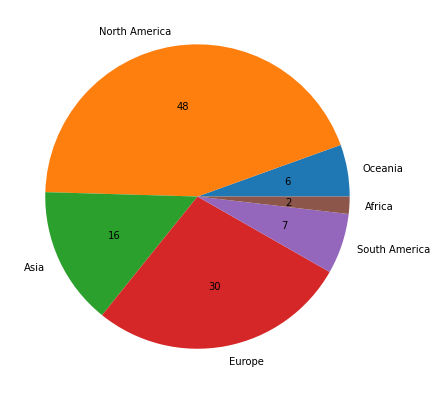

In [3]:
d = {}
for name in join['UA_Continent']:
    if name not in d:
        d[name] = 1
    else:
        d[name] += 1
        
cnt = join.shape[0]
counts = []
labels = []
for key in d:
    labels.append(key)
    counts.append(d[key])

fig1, ax1 = plt.subplots(figsize=(7,7))

def value(a):
    return int(np.round((a/100)*cnt,0))

ax1.pie(counts, labels=labels, autopct=value)
plt.show()

The plot above shows how much cities we have from each continent. Unfortunately, dataset is unbalanced which is likely to cause problems later on. The decision has been made to drop 2 entries from Africa since it will certainly be not enough to train and test a model

In [4]:
base_data = join[join["UA_Continent"] != "Africa"]
fn = lambda row: (row.GDP * 1e9) / row.population # define a function for the new column
col = base_data.apply(fn, axis=1) # get column data with an index
base_data = base_data.assign(gdppc=col.values) # assign values to column 'c'
base_data

,city,lat,lng,population,area,UA_Continent,Housing,Cost of Living,Startups,Venture Capital,...,Outdoors,GDP,Air quality,Water Pollution,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,gdppc
0,Adelaide,-34.9350,138.6000,1145000.0,729,Oceania,6.3095,4.692,3.1365,2.640,...,5.5310,47.433,88.848039,24.605263,72.92,31.99,67.23,68.26,127.17,41426.200873
1,Albuquerque,35.1053,-106.6464,758523.0,580,North America,7.2620,6.059,3.7720,1.493,...,3.5155,39.913,83.333333,39.705882,64.32,27.29,64.42,63.21,128.27,52619.366848
2,Ankara,39.9272,32.8644,3716000.0,583,Asia,9.9280,9.125,3.9725,0.000,...,5.1465,104.863,38.908451,57.954545,34.77,6.56,29.59,25.13,64.55,28219.321851
3,Athens,39.3269,23.7333,3242000.0,684,Europe,9.0525,6.500,4.4040,2.325,...,6.4830,129.623,44.174121,30.315615,60.44,12.73,44.92,62.38,52.48,39982.418260
4,Atlanta,33.7627,-84.4225,5228750.0,5083,North America,4.9755,5.241,8.8350,7.257,...,5.0095,294.420,59.687500,46.575342,72.05,46.89,66.94,73.06,150.38,56307.912981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Toronto,43.7000,-79.4200,5213000.0,1655,North America,4.6600,5.271,9.9810,7.602,...,5.5940,276.313,65.534682,37.799401,70.19,44.28,64.15,67.53,99.45,53004.603875
105,Toulouse,43.6200,1.4499,847000.0,808,Europe,7.5440,4.552,3.5770,2.042,...,3.3040,47.384,61.290323,39.423077,76.30,23.03,66.45,74.72,105.57,55943.329398
106,Vancouver,49.2734,-122.5970,2313328.0,1120,North America,4.0805,5.259,8.1700,5.842,...,7.4000,109.805,80.569307,31.666667,69.63,49.26,66.65,67.35,94.65,47466.247761
107,Warsaw,52.2500,21.0000,1707000.0,466,Europe,7.8695,8.192,6.1215,1.853,...,4.9610,141.096,27.272727,36.014851,42.32,20.60,31.63,39.89,76.34,82657.293497


In [5]:
gdf = gpd.GeoDataFrame(base_data, geometry=gpd.points_from_xy(base_data.lng, base_data.lat))
gdf

,city,lat,lng,population,area,UA_Continent,Housing,Cost of Living,Startups,Venture Capital,...,GDP,Air quality,Water Pollution,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,gdppc,geometry
0,Adelaide,-34.9350,138.6000,1145000.0,729,Oceania,6.3095,4.692,3.1365,2.640,...,47.433,88.848039,24.605263,72.92,31.99,67.23,68.26,127.17,41426.200873,POINT (138.60000 -34.93500)
1,Albuquerque,35.1053,-106.6464,758523.0,580,North America,7.2620,6.059,3.7720,1.493,...,39.913,83.333333,39.705882,64.32,27.29,64.42,63.21,128.27,52619.366848,POINT (-106.64640 35.10530)
2,Ankara,39.9272,32.8644,3716000.0,583,Asia,9.9280,9.125,3.9725,0.000,...,104.863,38.908451,57.954545,34.77,6.56,29.59,25.13,64.55,28219.321851,POINT (32.86440 39.92720)
3,Athens,39.3269,23.7333,3242000.0,684,Europe,9.0525,6.500,4.4040,2.325,...,129.623,44.174121,30.315615,60.44,12.73,44.92,62.38,52.48,39982.418260,POINT (23.73330 39.32690)
4,Atlanta,33.7627,-84.4225,5228750.0,5083,North America,4.9755,5.241,8.8350,7.257,...,294.420,59.687500,46.575342,72.05,46.89,66.94,73.06,150.38,56307.912981,POINT (-84.42250 33.76270)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Toronto,43.7000,-79.4200,5213000.0,1655,North America,4.6600,5.271,9.9810,7.602,...,276.313,65.534682,37.799401,70.19,44.28,64.15,67.53,99.45,53004.603875,POINT (-79.42000 43.70000)
105,Toulouse,43.6200,1.4499,847000.0,808,Europe,7.5440,4.552,3.5770,2.042,...,47.384,61.290323,39.423077,76.30,23.03,66.45,74.72,105.57,55943.329398,POINT (1.44990 43.62000)
106,Vancouver,49.2734,-122.5970,2313328.0,1120,North America,4.0805,5.259,8.1700,5.842,...,109.805,80.569307,31.666667,69.63,49.26,66.65,67.35,94.65,47466.247761,POINT (-122.59700 49.27340)
107,Warsaw,52.2500,21.0000,1707000.0,466,Europe,7.8695,8.192,6.1215,1.853,...,141.096,27.272727,36.014851,42.32,20.60,31.63,39.89,76.34,82657.293497,POINT (21.00000 52.25000)


The purpose of figure below was to plot all cities on a map, however it turned out that a lot of cities have incorrect coordinates (the other attributes have reasonable values). Hence this is the first and last plot on a map (unfortunately).

<AxesSubplot:>

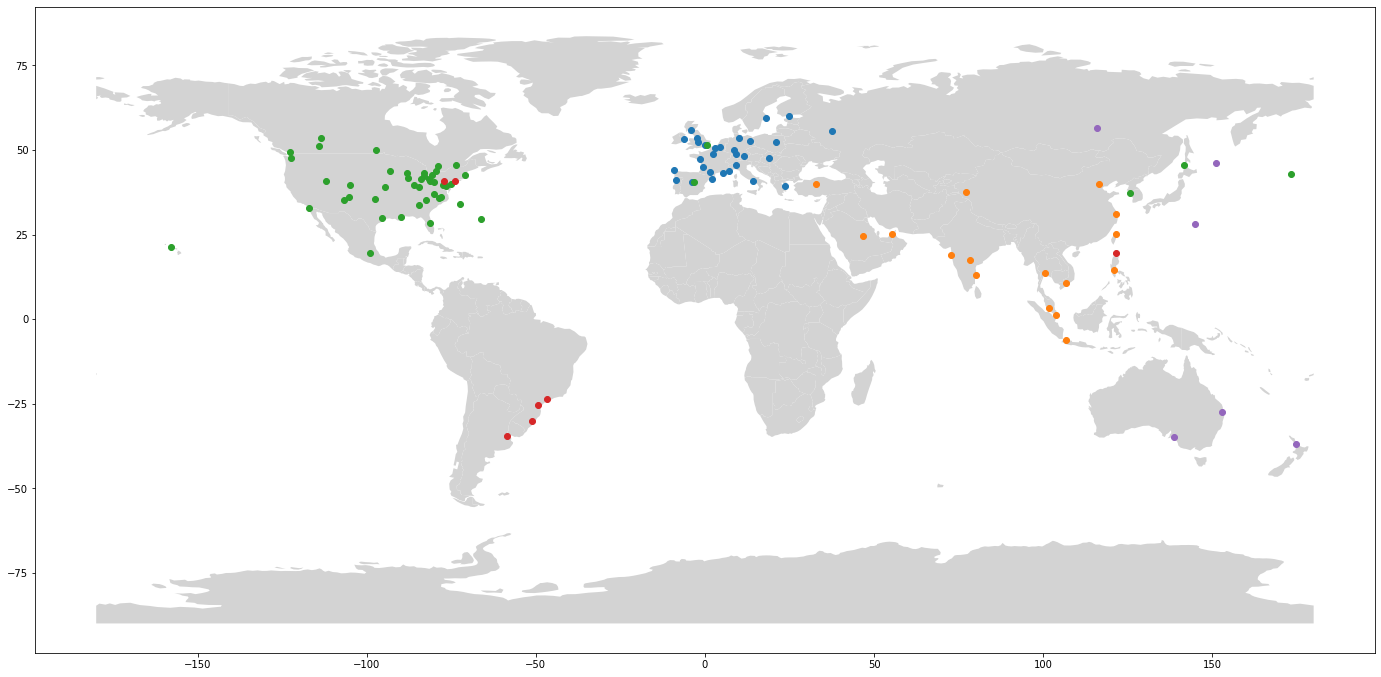

In [6]:
fig, ax = plt.subplots(figsize=(24, 12))
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap.plot(color="lightgrey", ax=ax)
gdf[gdf["UA_Continent"] == "Europe"].plot(ax=ax)
gdf[gdf["UA_Continent"] == "Asia"].plot(ax=ax)
gdf[gdf["UA_Continent"] == "North America"].plot(ax=ax)
gdf[gdf["UA_Continent"] == "South America"].plot(ax=ax)
gdf[gdf["UA_Continent"] == "Oceania"].plot(ax=ax)

In [7]:
del base_data["lat"]
del base_data["lng"]
del base_data["geometry"]

In [8]:
eu = base_data[base_data["UA_Continent"] == "Europe"]
asia = base_data[base_data["UA_Continent"] == "Asia"]
na = base_data[base_data["UA_Continent"] == "North America"]
sa = base_data[base_data["UA_Continent"] == "South America"]
au = base_data[base_data["UA_Continent"] == "Oceania"]

Now let's prepare some boxplots to better understand the distribution of the data across continents

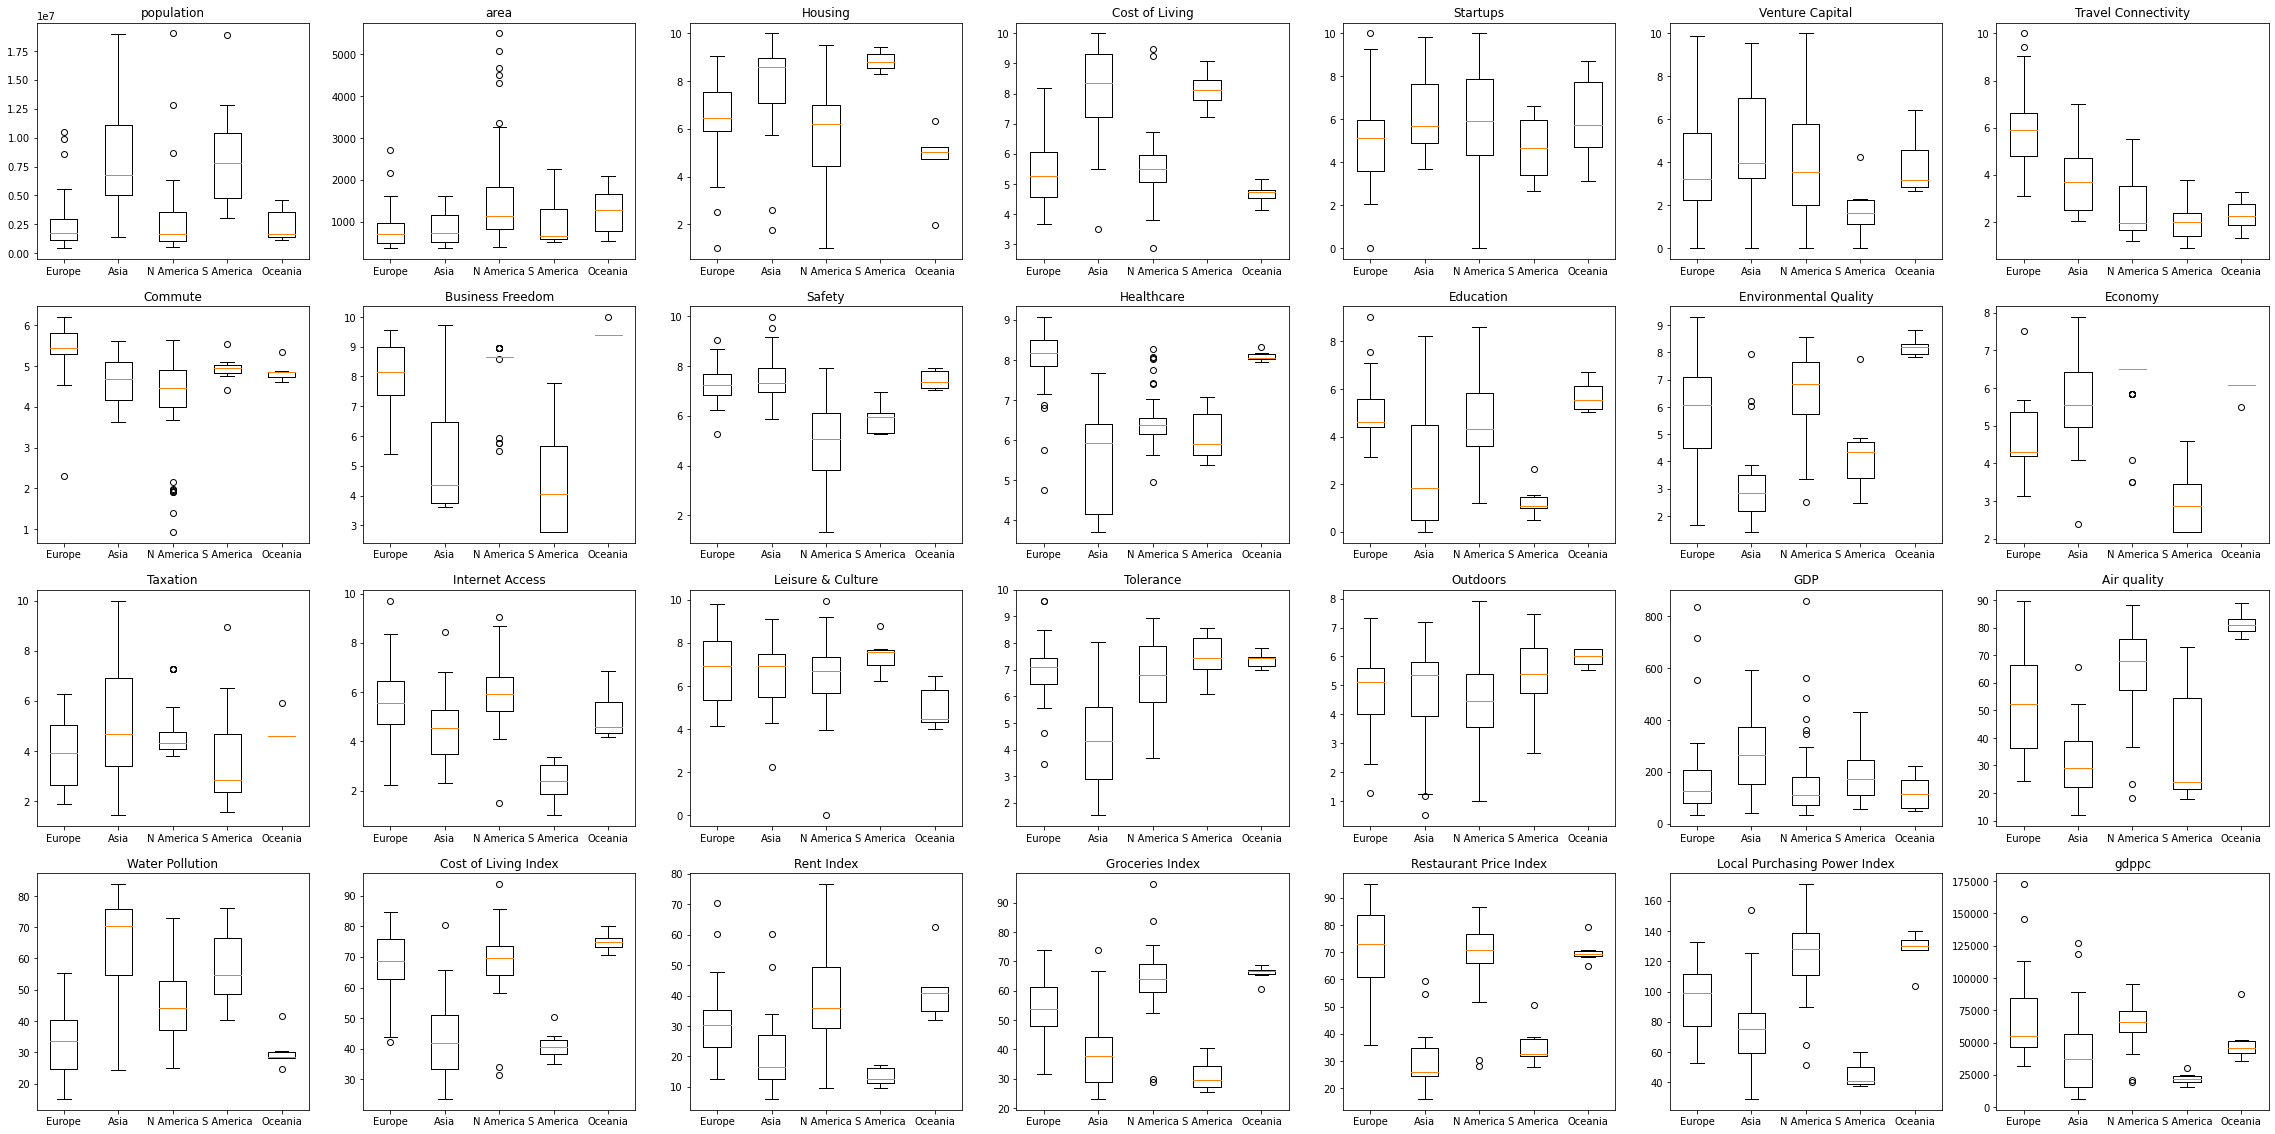

In [9]:
df = base_data.copy()
del df['city']
del df['UA_Continent']

plt_width = 7
plt_height = 4

fig, axs = plt.subplots(plt_height, plt_width, figsize=(40,20))

for col,cords in zip(df.columns,list(itertools.product(list(range(plt_height)),list(range(plt_width))))):
    axs[cords[0],cords[1]].boxplot([x[col] for x in [eu,asia,na,sa,au]], labels = ["Europe", "Asia", "N America", "S America", "Oceania"])
    axs[cords[0],cords[1]].set_title(col)

plt.show()

Many features seem to have similair distributions across all continents, which is not really helpful. Still there are also some attributes which differ, however it is worth pointing out that countries from Europe, North America and Oceania (which is basically Australia and New Zeland) have usually similar distribution and so do Africa and Asia. Hence it might be hard for a model to differentiate between continents in those two groups.

Also, even though both Oceania and South America have low number of entries, the cities in South America seem to have much bigger diffrences than cities in Oceania.

Now let's plot some correlation matrices

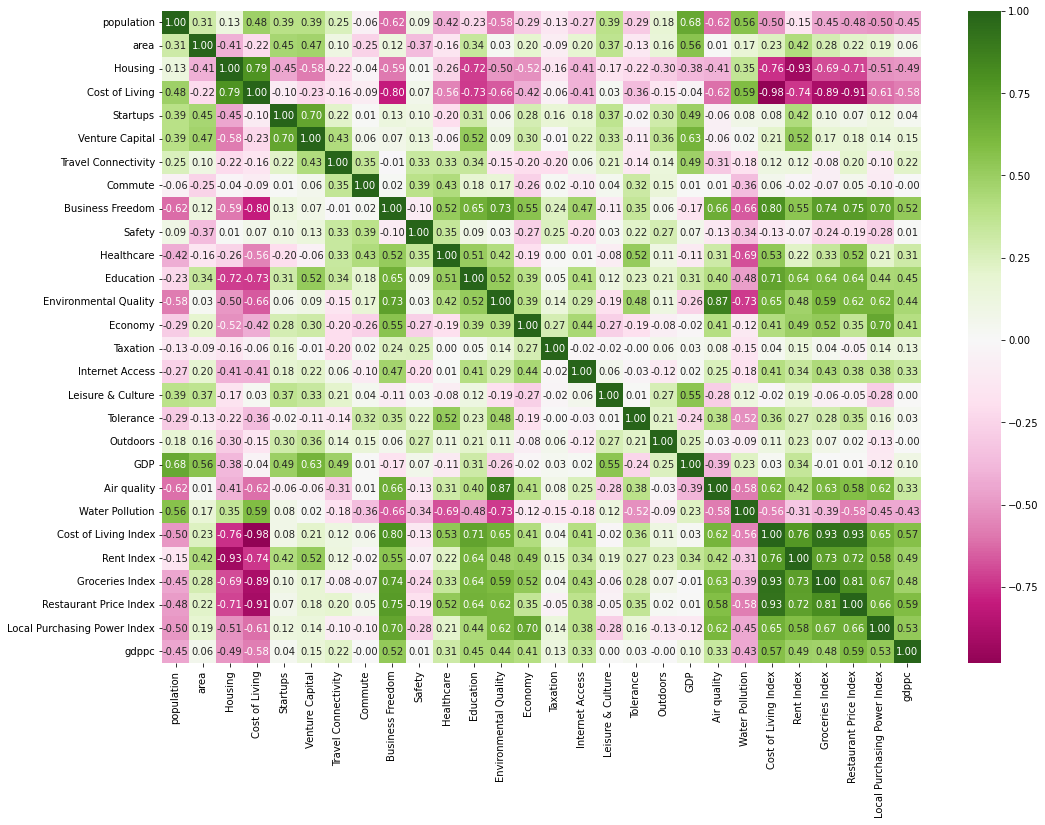

In [10]:
f, ax = plt.subplots(figsize=(17, 12))
ax = sb.heatmap(base_data.corr(), center=0, cmap="PiYG", annot=True, fmt=".2f")

We have a lot of features and some of thos are highly correlated with each other. Especially various price indices (there are even 2 cost of living indices). It might be good to do some feature selection.

There are also some suprising correlations: for example cost of living seems to be correlated with all enviromental attributes. Let's if it also looks like that in correlation matrix for one continent

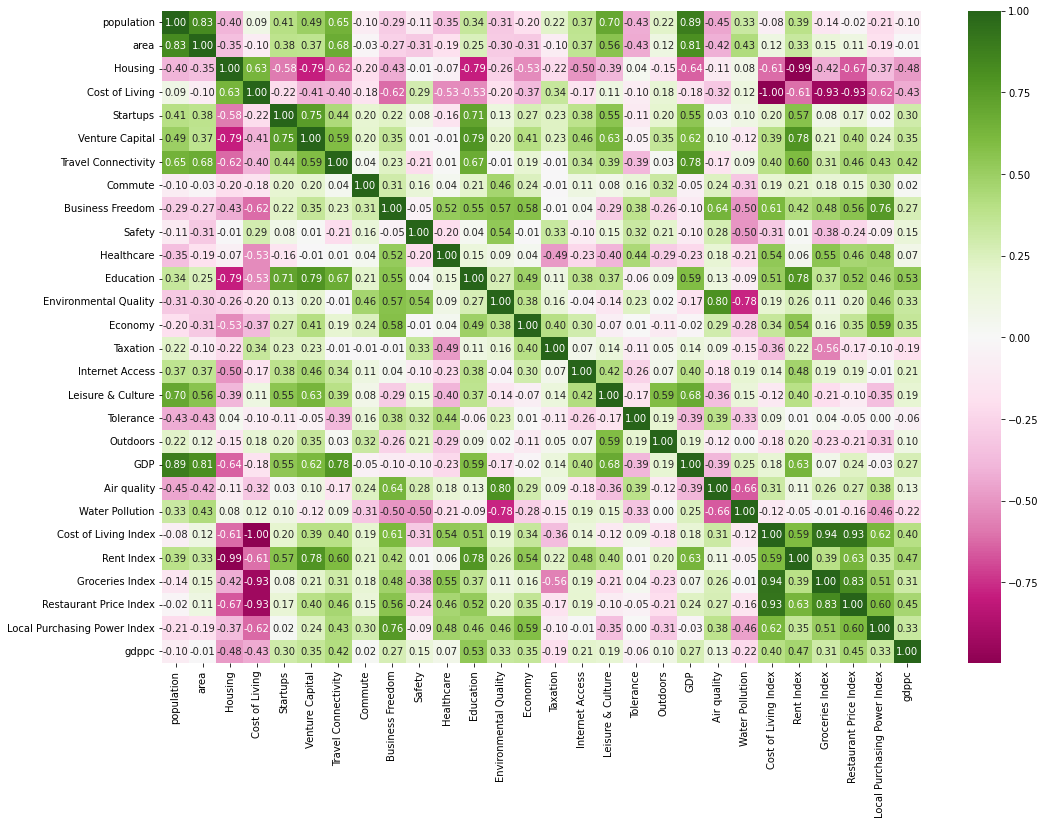

In [11]:
f, ax = plt.subplots(figsize=(17, 12))
ax = sb.heatmap(eu.corr(), center=0, cmap="PiYG", annot=True, fmt=".2f")

If we only take European cities then cost of living is no longer correlated with enviromental pollution. Also a lot of other things have changed in the matrix

In [12]:
map_con = {
    "Europe":0,
    "Asia":1,
    "North America":2,
    "South America":3,
    "Oceania":4
}
fn = lambda row: map_con[row.UA_Continent] # define a function for the new column
col = base_data.apply(fn, axis=1) # get column data with an index
cat_data = base_data.assign(continent=col.values) # assign values to column

In [13]:
del cat_data["UA_Continent"]
cat_data

,city,population,area,Housing,Cost of Living,Startups,Venture Capital,Travel Connectivity,Commute,Business Freedom,...,GDP,Air quality,Water Pollution,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,gdppc,continent
0,Adelaide,1145000.0,729,6.3095,4.692,3.1365,2.640,1.7765,5.33625,9.399667,...,47.433,88.848039,24.605263,72.92,31.99,67.23,68.26,127.17,41426.200873,4
1,Albuquerque,758523.0,580,7.2620,6.059,3.7720,1.493,1.4555,5.05575,8.671000,...,39.913,83.333333,39.705882,64.32,27.29,64.42,63.21,128.27,52619.366848,2
2,Ankara,3716000.0,583,9.9280,9.125,3.9725,0.000,2.0475,5.29100,5.948333,...,104.863,38.908451,57.954545,34.77,6.56,29.59,25.13,64.55,28219.321851,1
3,Athens,3242000.0,684,9.0525,6.500,4.4040,2.325,3.7070,5.21975,6.169000,...,129.623,44.174121,30.315615,60.44,12.73,44.92,62.38,52.48,39982.418260,0
4,Atlanta,5228750.0,5083,4.9755,5.241,8.8350,7.257,5.2915,3.89775,8.671000,...,294.420,59.687500,46.575342,72.05,46.89,66.94,73.06,150.38,56307.912981,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Toronto,5213000.0,1655,4.6600,5.271,9.9810,7.602,4.3350,4.68300,8.966000,...,276.313,65.534682,37.799401,70.19,44.28,64.15,67.53,99.45,53004.603875,2
105,Toulouse,847000.0,808,7.5440,4.552,3.5770,2.042,5.1265,5.06775,8.088333,...,47.384,61.290323,39.423077,76.30,23.03,66.45,74.72,105.57,55943.329398,0
106,Vancouver,2313328.0,1120,4.0805,5.259,8.1700,5.842,2.7710,4.93675,8.966000,...,109.805,80.569307,31.666667,69.63,49.26,66.65,67.35,94.65,47466.247761,2
107,Warsaw,1707000.0,466,7.8695,8.192,6.1215,1.853,3.8640,5.20300,5.704333,...,141.096,27.272727,36.014851,42.32,20.60,31.63,39.89,76.34,82657.293497,0


In [14]:
conts = ["Europe","Asia","North America","South America","Oceania"]
nums = list(range(5))

Now let's plot some graphs to illustrate the correlation or lack of correlation that we learned from correlation matrices

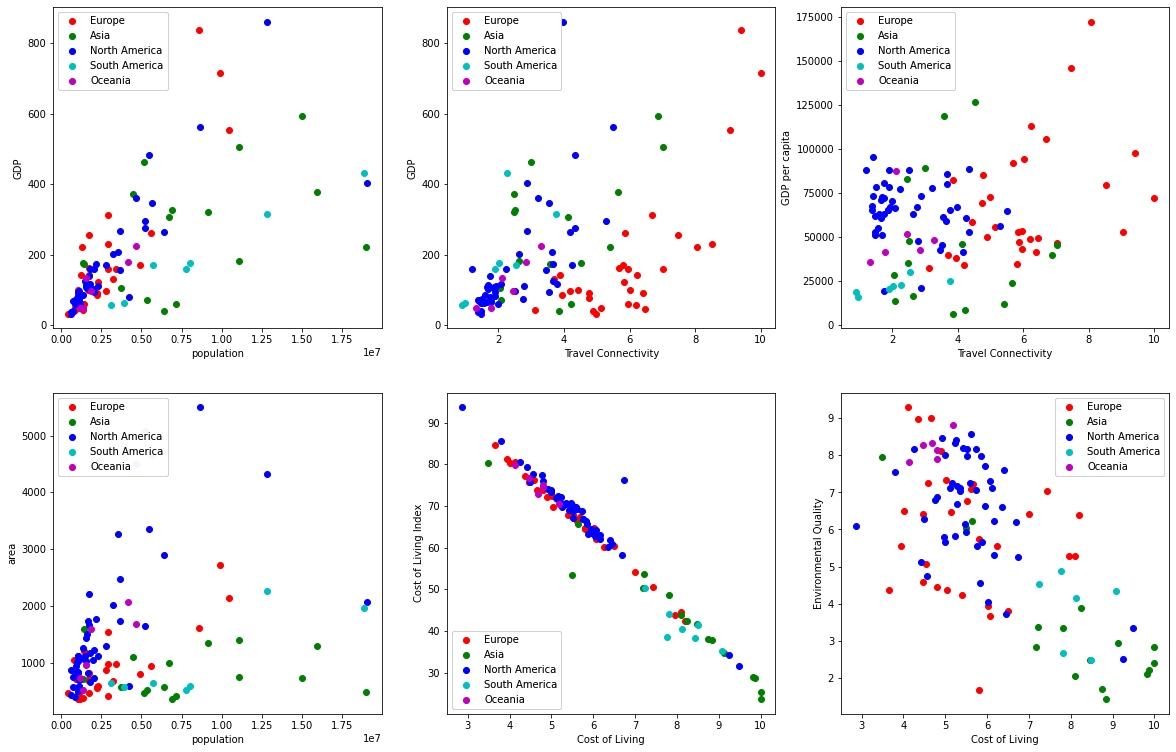

In [44]:
colors = ['r','g','b','y','c']
fig, ax = plt.subplots(2,3,figsize=(20,13))
a = ax[0,0].scatter(cat_data[cat_data["continent"]==0]["population"],cat_data[cat_data["continent"]==0]["GDP"], label='Europe', c = 'r')
b = ax[0,0].scatter(cat_data[cat_data["continent"]==1]["population"],cat_data[cat_data["continent"]==1]["GDP"], label='Asia', c = 'g')
c = ax[0,0].scatter(cat_data[cat_data["continent"]==2]["population"],cat_data[cat_data["continent"]==2]["GDP"], label='North America', c = 'b')
d = ax[0,0].scatter(cat_data[cat_data["continent"]==3]["population"],cat_data[cat_data["continent"]==3]["GDP"], label='South America', c = 'c')
e = ax[0,0].scatter(cat_data[cat_data["continent"]==4]["population"],cat_data[cat_data["continent"]==4]["GDP"], label='Oceania', c = 'm')
ax[0,0].set_xlabel("population")
ax[0,0].set_ylabel("GDP")
legend1 = ax[0,0].legend(handles = [a,b,c,d,e], labels = conts,loc="upper left")
ax[0,0].add_artist(legend1)

a = ax[0,1].scatter(cat_data[cat_data["continent"]==0]["Travel Connectivity"],cat_data[cat_data["continent"]==0]["GDP"], label='Europe', c = 'r')
b = ax[0,1].scatter(cat_data[cat_data["continent"]==1]["Travel Connectivity"],cat_data[cat_data["continent"]==1]["GDP"], label='Asia', c = 'g')
c = ax[0,1].scatter(cat_data[cat_data["continent"]==2]["Travel Connectivity"],cat_data[cat_data["continent"]==2]["GDP"], label='North America', c = 'b')
d = ax[0,1].scatter(cat_data[cat_data["continent"]==3]["Travel Connectivity"],cat_data[cat_data["continent"]==3]["GDP"], label='South America', c = 'c')
e = ax[0,1].scatter(cat_data[cat_data["continent"]==4]["Travel Connectivity"],cat_data[cat_data["continent"]==4]["GDP"], label='Oceania', c = 'm')
ax[0,1].set_xlabel("Travel Connectivity")
ax[0,1].set_ylabel("GDP")
legend1 = ax[0,1].legend(handles = [a,b,c,d,e], labels = conts,loc="upper left")
ax[0,1].add_artist(legend1)

a = ax[0,2].scatter(cat_data[cat_data["continent"]==0]["Travel Connectivity"],cat_data[cat_data["continent"]==0]["gdppc"], label='Europe', c = 'r')
b = ax[0,2].scatter(cat_data[cat_data["continent"]==1]["Travel Connectivity"],cat_data[cat_data["continent"]==1]["gdppc"], label='Asia', c = 'g')
c = ax[0,2].scatter(cat_data[cat_data["continent"]==2]["Travel Connectivity"],cat_data[cat_data["continent"]==2]["gdppc"], label='North America', c = 'b')
d = ax[0,2].scatter(cat_data[cat_data["continent"]==3]["Travel Connectivity"],cat_data[cat_data["continent"]==3]["gdppc"], label='South America', c = 'c')
e = ax[0,2].scatter(cat_data[cat_data["continent"]==4]["Travel Connectivity"],cat_data[cat_data["continent"]==4]["gdppc"], label='Oceania', c = 'm')
ax[0,2].set_xlabel("Travel Connectivity")
ax[0,2].set_ylabel("GDP per capita")
legend1 = ax[0,2].legend(handles = [a,b,c,d,e], labels = conts,loc="upper left")
ax[0,2].add_artist(legend1)

a = ax[1,0].scatter(cat_data[cat_data["continent"]==0]["population"],cat_data[cat_data["continent"]==0]["area"], label='Europe', c = 'r')
b = ax[1,0].scatter(cat_data[cat_data["continent"]==1]["population"],cat_data[cat_data["continent"]==1]["area"], label='Asia', c = 'g')
c = ax[1,0].scatter(cat_data[cat_data["continent"]==2]["population"],cat_data[cat_data["continent"]==2]["area"], label='North America', c = 'b')
d = ax[1,0].scatter(cat_data[cat_data["continent"]==3]["population"],cat_data[cat_data["continent"]==3]["area"], label='South America', c = 'c')
e = ax[1,0].scatter(cat_data[cat_data["continent"]==4]["population"],cat_data[cat_data["continent"]==4]["area"], label='Oceania', c = 'm')
ax[1,0].set_xlabel("population")
ax[1,0].set_ylabel("area")
legend1 = ax[1,0].legend(handles = [a,b,c,d,e], labels = conts,loc="upper left")
ax[1,0].add_artist(legend1)

a = ax[1,1].scatter(cat_data[cat_data["continent"]==0]["Cost of Living"],cat_data[cat_data["continent"]==0]["Cost of Living Index"], label='Europe', c = 'r')
b = ax[1,1].scatter(cat_data[cat_data["continent"]==1]["Cost of Living"],cat_data[cat_data["continent"]==1]["Cost of Living Index"], label='Asia', c = 'g')
c = ax[1,1].scatter(cat_data[cat_data["continent"]==2]["Cost of Living"],cat_data[cat_data["continent"]==2]["Cost of Living Index"], label='North America', c = 'b')
d = ax[1,1].scatter(cat_data[cat_data["continent"]==3]["Cost of Living"],cat_data[cat_data["continent"]==3]["Cost of Living Index"], label='South America', c = 'c')
e = ax[1,1].scatter(cat_data[cat_data["continent"]==4]["Cost of Living"],cat_data[cat_data["continent"]==4]["Cost of Living Index"], label='Oceania', c = 'm')
ax[1,1].set_xlabel("Cost of Living")
ax[1,1].set_ylabel("Cost of Living Index")
legend1 = ax[1,1].legend(handles = [a,b,c,d,e], labels = conts,loc="lower left")
ax[1,1].add_artist(legend1)

a = ax[1,2].scatter(cat_data[cat_data["continent"]==0]["Cost of Living"],cat_data[cat_data["continent"]==0]["Environmental Quality"], label='Europe', c = 'r')
b = ax[1,2].scatter(cat_data[cat_data["continent"]==1]["Cost of Living"],cat_data[cat_data["continent"]==1]["Environmental Quality"], label='Asia', c = 'g')
c = ax[1,2].scatter(cat_data[cat_data["continent"]==2]["Cost of Living"],cat_data[cat_data["continent"]==2]["Environmental Quality"], label='North America', c = 'b')
d = ax[1,2].scatter(cat_data[cat_data["continent"]==3]["Cost of Living"],cat_data[cat_data["continent"]==3]["Environmental Quality"], label='South America', c = 'c')
e = ax[1,2].scatter(cat_data[cat_data["continent"]==4]["Cost of Living"],cat_data[cat_data["continent"]==4]["Environmental Quality"], label='Oceania', c = 'm')
ax[1,2].set_xlabel("Cost of Living")
ax[1,2].set_ylabel("Environmental Quality")
legend1 = ax[1,2].legend(handles = [a,b,c,d,e], labels = conts,loc="upper right")
ax[1,2].add_artist(legend1)

In the first plot ot it is interesting to see how population correlates with GDP. In most of the continents the correlation is linear, and also it is clearly visible that Europe and North America make much more GDP from the same number of population than South America. However, Asia is all over the place and there is not really any correlation visible between these attributes on this continent. It might be pointing out that Asia is the most diverse continent and its cultures differ much more from each other than in other continets in this notebook. 

Graphs containing travel connectivity and gdp data show some nice clusters (although they are still far from perfect, and they mix a lot). It is clearly visible that Europe is probably the best continent in terms of travel connectivity

Population and area also seem to have linear correlation in each of the continent seperately. Although there are some visible outliers on this plot.

On the plot with cost of living we can see that both of the data sources generally agree with each other. We can also see that South America and Asia have usually lower cost of living than other continents

The last graph shows little correlation within each continent, but a pretty visible correlation in general. We can see that Oceania, Europe and North America have good evironmental quality and high cost of living, the situation is totally different in Asia and South America.

In [16]:
unlabeled_data = base_data.copy()
del unlabeled_data["UA_Continent"]
unlabeled_data = unlabeled_data.set_index("city")
unlabeled_data

,population,area,Housing,Cost of Living,Startups,Venture Capital,Travel Connectivity,Commute,Business Freedom,Safety,...,Outdoors,GDP,Air quality,Water Pollution,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,gdppc
city,,,,,,,,,,,,,,,,,,,,,
Adelaide,1145000.0,729,6.3095,4.692,3.1365,2.640,1.7765,5.33625,9.399667,7.9260,...,5.5310,47.433,88.848039,24.605263,72.92,31.99,67.23,68.26,127.17,41426.200873
Albuquerque,758523.0,580,7.2620,6.059,3.7720,1.493,1.4555,5.05575,8.671000,1.3435,...,3.5155,39.913,83.333333,39.705882,64.32,27.29,64.42,63.21,128.27,52619.366848
Ankara,3716000.0,583,9.9280,9.125,3.9725,0.000,2.0475,5.29100,5.948333,7.4250,...,5.1465,104.863,38.908451,57.954545,34.77,6.56,29.59,25.13,64.55,28219.321851
Athens,3242000.0,684,9.0525,6.500,4.4040,2.325,3.7070,5.21975,6.169000,6.7585,...,6.4830,129.623,44.174121,30.315615,60.44,12.73,44.92,62.38,52.48,39982.418260
Atlanta,5228750.0,5083,4.9755,5.241,8.8350,7.257,5.2915,3.89775,8.671000,2.6725,...,5.0095,294.420,59.687500,46.575342,72.05,46.89,66.94,73.06,150.38,56307.912981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toronto,5213000.0,1655,4.6600,5.271,9.9810,7.602,4.3350,4.68300,8.966000,7.6935,...,5.5940,276.313,65.534682,37.799401,70.19,44.28,64.15,67.53,99.45,53004.603875
Toulouse,847000.0,808,7.5440,4.552,3.5770,2.042,5.1265,5.06775,8.088333,6.9670,...,3.3040,47.384,61.290323,39.423077,76.30,23.03,66.45,74.72,105.57,55943.329398
Vancouver,2313328.0,1120,4.0805,5.259,8.1700,5.842,2.7710,4.93675,8.966000,7.5695,...,7.4000,109.805,80.569307,31.666667,69.63,49.26,66.65,67.35,94.65,47466.247761


Now we will do some clustering to see how k means would group these cities together

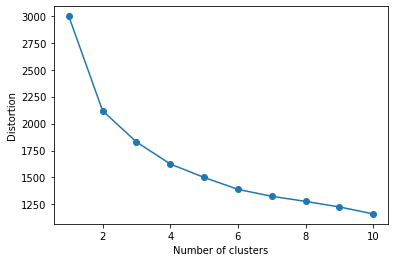

In [17]:
#copied from https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
X = StandardScaler().fit_transform(unlabeled_data)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

It looks like 2 clusters is the best option for clustering here, however the cities will be classified later into 5 clusters (this is the number of labels)

In [18]:
num_of_clusters=2
X = StandardScaler().fit_transform(unlabeled_data)
kmeans = KMeans(n_clusters=num_of_clusters,random_state=14)
model = kmeans.fit(X)
clusters = kmeans.predict(X)
clustering_results = unlabeled_data.copy()
clustering_results["cluster"] = clusters
for x in range(num_of_clusters):
    print("///////////////////////cluster " + str(x) + "///////////////////////")
    print(clustering_results[clustering_results["cluster"] == x].index)

///////////////////////cluster 0///////////////////////
Index(['Adelaide', 'Albuquerque', 'Atlanta', 'Auckland', 'Austin', 'Baltimore',
       'Barcelona', 'Berlin', 'Birmingham', 'Bordeaux', 'Boston', 'Brisbane',
       'Brussels', 'Buffalo', 'Calgary', 'Charlotte', 'Chicago', 'Cincinnati',
       'Cleveland', 'Columbus', 'Denver', 'Detroit', 'Dubai', 'Dublin',
       'Edmonton', 'Frankfurt', 'Glasgow', 'Hamburg', 'Helsinki', 'Honolulu',
       'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City', 'Knoxville',
       'Las Vegas', 'Lille', 'Lisbon', 'London', 'Los Angeles', 'Louisville',
       'Madrid', 'Manchester', 'Marseille', 'Melbourne', 'Memphis', 'Miami',
       'Milan', 'Milwaukee', 'Montreal', 'Munich', 'Nantes', 'Nashville',
       'New Orleans', 'Nice', 'Oklahoma City', 'Orlando', 'Paris', 'Perth',
       'Philadelphia', 'Pittsburgh', 'Portland', 'Porto', 'Raleigh',
       'Richmond', 'Rochester', 'Salt Lake City', 'San Antonio', 'San Diego',
       'San Jose', 'Seattle

If we try to seperate the cities into two groups we get a really nice geographic division. The first world created by the clusterer contains all cities from USA, Canada, western Europe, Australia and New Zealand. There are however two exceptions and that is Taipei and Singapore - the only cities from Asia here. These are the developed cities located in rich countries with a highest standards of living in the world. 
The second world contains cities from countries which are not as developed as countries from the 1st cluster. There are however even few cities from Europe in this cluster. The most interesting thing is how Naples has been classified in 2nd world and Milan in the 1st world. This makes Italy the only country to have cities in both clusters

Kmeans managed to seperate all North American and Oceanian cities from South American cities, however it split Europe into two clusters and almost managed to combine all Asian cities in one cluster

Let's see how clustering with 5 clusters will work

In [19]:
num_of_clusters=5
X = StandardScaler().fit_transform(unlabeled_data)
kmeans = KMeans(n_clusters=num_of_clusters,random_state=14)
model = kmeans.fit(X)
clusters = kmeans.predict(X)
clustering_results = unlabeled_data.copy()
clustering_results["cluster"] = clusters
for x in range(num_of_clusters):
    print("///////////////////////cluster " + str(x) + "///////////////////////")
    print(clustering_results[clustering_results["cluster"] == x].index)

///////////////////////cluster 0///////////////////////
Index(['Adelaide', 'Auckland', 'Berlin', 'Brisbane', 'Calgary', 'Denver',
       'Dubai', 'Dublin', 'Edmonton', 'Hamburg', 'Helsinki', 'Melbourne',
       'Montreal', 'Munich', 'Perth', 'Portland', 'Singapore', 'Stockholm',
       'Sydney', 'Taipei', 'Toronto', 'Vancouver'],
      dtype='object', name='city')
///////////////////////cluster 1///////////////////////
Index(['Athens', 'Barcelona', 'Birmingham', 'Bordeaux', 'Brussels',
       'Frankfurt', 'Glasgow', 'Lille', 'Lisbon', 'Madrid', 'Manchester',
       'Marseille', 'Milan', 'Nantes', 'Naples', 'Nice', 'Porto', 'Stuttgart',
       'Toulouse'],
      dtype='object', name='city')
///////////////////////cluster 2///////////////////////
Index(['Ankara', 'Bangkok', 'Beijing', 'Bogota', 'Budapest', 'Buenos Aires',
       'Chennai', 'Curitiba', 'Delhi', 'Guadalajara', 'Ho Chi Minh City',
       'Hyderabad', 'Jakarta', 'Kuala Lumpur', 'Lima', 'Manila', 'Mexico City',
       'Moscow

These clusters also show clear connection with geographic regions, there are even clusters that contain cities only from one continent (1 & 3). However other clusters contain cities from various continents. It looks like the size of the city also played an important role in clustering rather than purely financial data. 

It is worth pointing out that there are a lot of attributes which describe prices in these cities so financial data probably dominated the clustering and diminished other attributes.

In [20]:
ml_data = cat_data.copy()
del ml_data["city"]
y = ml_data["continent"]
x = ml_data.copy()
del x["continent"]
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)

It is time to get to the classification. First a few models will be trained and tested on the same training and testing dataset.

In [22]:
#NBC
gnb = GaussianNB()
gnb.fit(x_train, y_train)
print(gnb.score(x_test,y_test))
pred = gnb.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.8823529411764706
[3 1 0 1 2 0 2 2 2 2 1 2 2 0 2 3 3]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]


In [23]:
#Logistic regression
model = LogisticRegression()
model.fit(x_train, y_train)
print(model.score(x_test,y_test))
pred = model.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.9411764705882353
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 1 3]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [24]:
#knn
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(x_train, y_train)
print(model.score(x_test,y_test))
pred = model.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.8235294117647058
[3 1 0 0 2 0 2 2 4 2 0 2 2 0 2 1 0]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1]


In [25]:
model = keras.Sequential([
	keras.layers.Dense(16, input_shape=(28,), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
	keras.layers.Dense(5, activation='sigmoid')])

model.compile(optimizer="adam", 
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                metrics = ["accuracy"])

In [26]:
model.fit(x_train, y_train, batch_size=1, epochs = 6)

Epoch 1/6
90/90 [==============================] - 0s 641us/step - loss: 1.9345 - accuracy: 0.1444
Epoch 2/6
90/90 [==============================] - 0s 619us/step - loss: 1.6362 - accuracy: 0.3333
Epoch 3/6
90/90 [==============================] - 0s 608us/step - loss: 1.5299 - accuracy: 0.3889
Epoch 4/6
90/90 [==============================] - 0s 619us/step - loss: 1.4551 - accuracy: 0.4889
Epoch 5/6
90/90 [==============================] - 0s 641us/step - loss: 1.3891 - accuracy: 0.5222
Epoch 6/6
90/90 [==============================] - 0s 631us/step - loss: 1.2682 - accuracy: 0.5556


In [27]:
evaluation = model.evaluate(x_test,y_test)

1/1 [==============================] - 0s 141ms/step - loss: 1.2139 - accuracy: 0.5294


In [28]:
#SVC
model = LinearSVC()
model.fit(x_train, y_train)
print(model.score(x_test,y_test))
pred = model.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.9411764705882353
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 1 3]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [29]:
#Tree
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
print(model.score(x_test,y_test))
pred = model.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.7058823529411765
[3 1 0 3 2 0 2 2 4 4 1 2 2 0 2 1 2]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1]


In [30]:
#Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
print(model.score(x_test,y_test))
pred = model.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.7647058823529411
[3 1 0 0 2 0 2 2 2 2 1 2 2 0 2 1 3]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0]


In [31]:
#Ada
model = AdaBoostClassifier(base_estimator=LogisticRegression(),algorithm="SAMME.R")
model.fit(x_train, y_train)
print(model.score(x_test,y_test))
pred = model.predict(x_test) 
print(pred)
print(y_test.values)
diffs = []
for p,t in zip(pred,y_test.values):
    diffs.append(0 if p==t else 1)
print(np.array(diffs))

0.8823529411764706
[3 1 0 3 2 0 2 2 4 2 1 2 2 0 2 3 3]
[3 1 0 1 2 0 2 2 4 2 0 2 2 0 2 3 3]
[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]


The results look surprisingly good. The neural network however doesn't seem to get a nice accuracy. Hence this model will not be taken into consideration later on.

It is great to see that despite the fact that we have very small number of cities from South America and Oceania, models still often correctly classify cities from these continents.

From the predictions above we can see that there is one city from South America that is being often classified as Asian. After going through the data it turned out that this city is Lima.

In [32]:
cat_data.reset_index().iloc[52]

index                                     54
city                                    Lima
population                         8012000.0
area                                     596
Housing                                8.712
Cost of Living                         8.496
Startups                              3.8835
Venture Capital                         1.65
Travel Connectivity                    2.012
Commute                                4.759
Business Freedom                    5.001667
Safety                                5.2905
Healthcare                          5.710667
Education                                0.5
Environmental Quality                2.48075
Economy                               3.1625
Taxation                               6.524
Internet Access                         2.41
Leisure & Culture                     6.8085
Tolerance                             6.0805
Outdoors                               5.388
GDP                                  176.447
Air qualit

Now lets test these models with feature selection. The indices in dataFrame represent number of features used in the model

In [33]:
d = {}
for features_cnt in range(1,28):
    X = SelectKBest(f_classif, k=features_cnt).fit_transform(x,y)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)
    for name,model in [("NBC",GaussianNB()),
                       ("Logistic Regression",LogisticRegression()),
                       ("KNN",KNeighborsClassifier(n_neighbors = 5)),
                       ("SVC",LinearSVC()),
                       ("Tree",DecisionTreeClassifier()),
                       ("Forest",RandomForestClassifier(n_estimators=100)),
                       ("Ada",AdaBoostClassifier(base_estimator=LogisticRegression(),algorithm="SAMME.R"))]:
        model.fit(x_train, y_train)
        sc = model.score(x_test,y_test)
        #print(name,features_cnt,sc)
        if name not in d:
            d[name] = [sc]
        else:
            d[name].append(sc)
            


In [34]:
res = pd.DataFrame(d,index= list(range(1,28)))
res

,NBC,Logistic Regression,KNN,SVC,Tree,Forest,Ada
1,0.470588,0.470588,0.411765,0.470588,0.294118,0.294118,0.294118
2,0.647059,0.764706,0.588235,0.764706,0.705882,0.647059,0.529412
3,0.705882,0.705882,0.647059,0.764706,0.764706,0.764706,0.588235
4,0.764706,0.705882,0.764706,0.764706,0.823529,0.823529,0.705882
5,0.705882,0.705882,0.705882,0.823529,0.764706,0.764706,0.764706
6,0.823529,0.764706,0.705882,0.823529,0.764706,0.823529,0.764706
7,0.764706,0.764706,0.764706,0.823529,0.705882,0.764706,0.764706
8,0.764706,0.705882,0.764706,0.823529,0.705882,0.764706,0.705882
9,0.764706,0.823529,0.764706,0.823529,0.764706,0.764706,0.705882
10,0.764706,0.823529,0.764706,0.823529,0.764706,0.705882,0.705882


It looks like decreasing the number of features would help some models to perform better (especially AdaBoost).

Finally to get rid of the bias caused by randomly selecting one training dataset, all of the models will be tested several times with different data using KFold. Each model will be trained and tested 6 times.

In [35]:
Y = y.to_numpy()
d = {}
splits = 6
kf = KFold(n_splits=splits,shuffle=True,random_state=12)
for features_cnt in range(1,28):
    X = SelectKBest(f_classif, k=features_cnt).fit_transform(x,y)
    for name,model in [("NBC",GaussianNB()),
                       ("Logistic Regression",LogisticRegression()),
                       ("KNN",KNeighborsClassifier(n_neighbors = 5)),
                       ("SVC",LinearSVC()),
                       ("Tree",DecisionTreeClassifier()),
                       ("Forest",RandomForestClassifier(n_estimators=100)),
                       ("Ada",AdaBoostClassifier(base_estimator=LogisticRegression(),algorithm="SAMME.R"))]:
        avg = 0
        for train_index, test_index in kf.split(X):
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            m = clone(model)
            m.fit(x_train, y_train)
            avg += m.score(x_test,y_test)
        avg/=splits
        if name not in d:
            d[name] = [avg]
        else:
            d[name].append(avg)

res = pd.DataFrame(d,index= list(range(1,28)))
res

,NBC,Logistic Regression,KNN,SVC,Tree,Forest,Ada
1,0.589869,0.562092,0.513072,0.562092,0.541394,0.541394,0.422658
2,0.757625,0.747821,0.710240,0.720044,0.681373,0.747821,0.663943
3,0.813181,0.766340,0.710784,0.747821,0.831699,0.868736,0.711329
4,0.850763,0.822985,0.812636,0.823529,0.840959,0.859477,0.813181
5,0.841503,0.841503,0.802832,0.822440,0.831155,0.868736,0.823529
6,0.832244,0.841503,0.783224,0.813725,0.850218,0.849673,0.813725
7,0.795207,0.832244,0.840414,0.832244,0.821895,0.859477,0.795207
8,0.813725,0.841503,0.830610,0.861111,0.841503,0.849673,0.841503
9,0.804466,0.842048,0.830610,0.879630,0.812092,0.840959,0.803922
10,0.804466,0.832244,0.849673,0.860022,0.812092,0.840959,0.813181


We can see that the results are much different than before which means that some algorithms were affected by the selection of training and test data. It is visible in Logistic regression, AdaBoost, Random Forest and to lesser extent in other models

Let's plot the results to see which model did the best job

<AxesSubplot:>

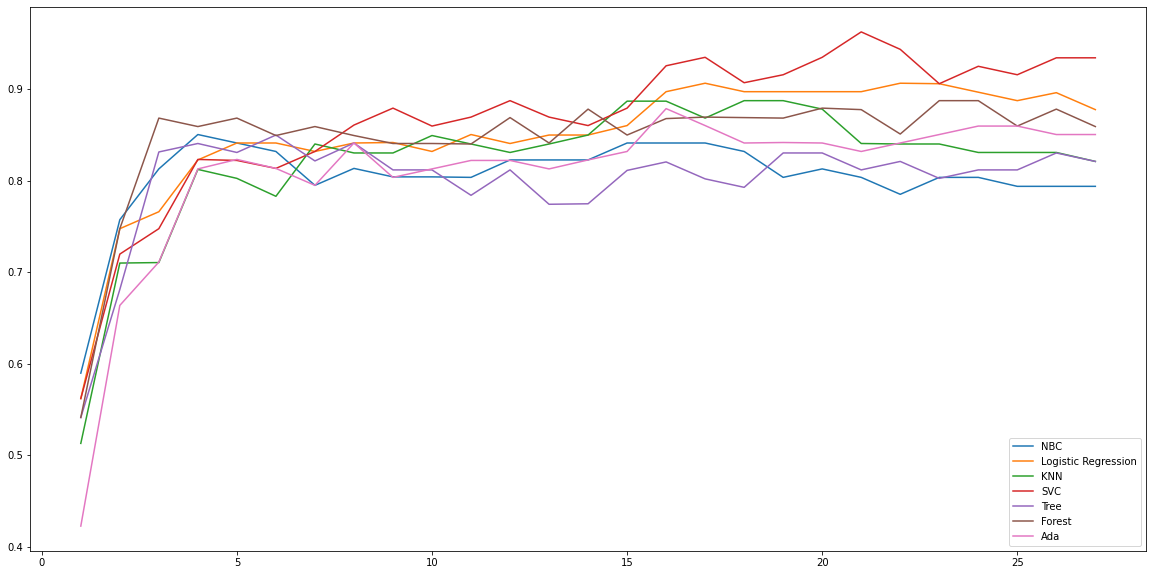

In [36]:
res.plot(figsize=(20,10))

Support Vector machine managed to get the highest score overall with 21 attributes. However random forest was the best with small number of features. Naive Bayes was doing pretty well with small number of features but when the number of features increased, the model got confused. 

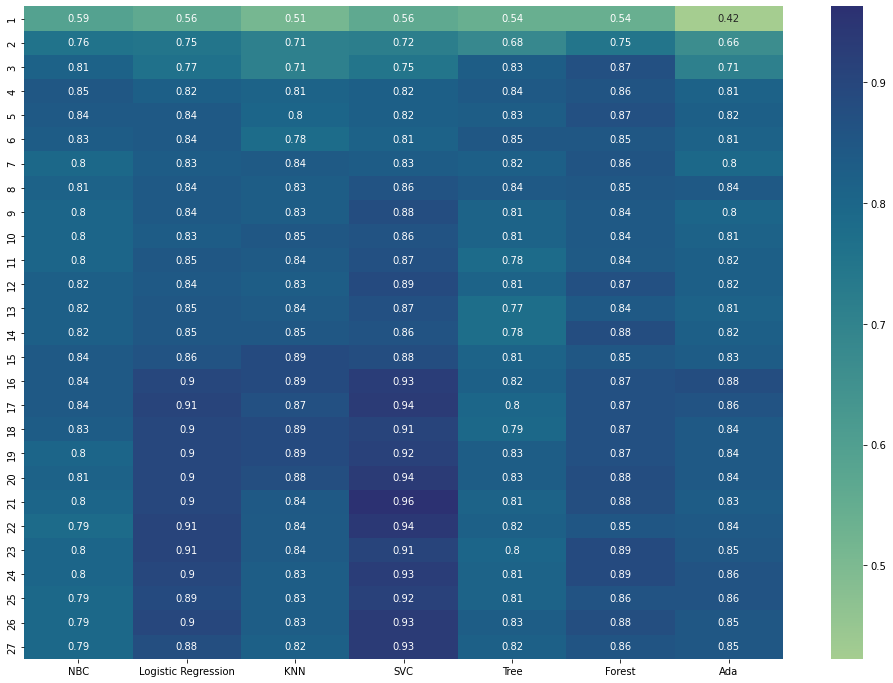

In [37]:
f, ax = plt.subplots(figsize=(17, 12))
ax = sb.heatmap(res, annot = True, cmap="crest")

On these plots we can see that SVC model did the best job, followed by logistic regression. KNN and random tree also managed to get nice scores when given the optimal number of features.

Now let's what features were used in the best SVC model

In [38]:
select = SelectKBest(f_classif, k=21)
select.fit_transform(x,y)
select.scores_

array([10.45136434,  4.30566628,  7.97799797, 20.13113233,  1.88951769,
        1.83456073, 33.49554652,  9.58497187, 33.38606067, 21.62624867,
       28.50595718, 12.72708723, 17.14710577, 29.73209731,  2.37147132,
       12.14583748,  2.16123491, 13.15451405,  1.48802926,  1.39944901,
       19.8053852 , 19.91884651, 25.79720474, 10.26749576, 25.33261056,
       39.41170299, 27.63058165,  6.39967091])

In [39]:
x = ml_data.copy()
del x["continent"]
x.columns

Index(['population', 'area', 'Housing', 'Cost of Living', 'Startups',
       'Venture Capital', 'Travel Connectivity', 'Commute', 'Business Freedom',
       'Safety', 'Healthcare', 'Education', 'Environmental Quality', 'Economy',
       'Taxation', 'Internet Access', 'Leisure & Culture', 'Tolerance',
       'Outdoors', 'GDP', 'Air quality', 'Water Pollution',
       'Cost of Living Index', 'Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index', 'gdppc'],
      dtype='object')

In [40]:
sorted_scores = sorted(list(zip(select.scores_,x.columns)),key= lambda x:x[0], reverse=True)
sorted_scores

[(39.41170298622216, 'Restaurant Price Index'),
 (33.49554652385571, 'Travel Connectivity'),
 (33.386060667227646, 'Business Freedom'),
 (29.732097312224546, 'Economy'),
 (28.505957176144456, 'Healthcare'),
 (27.63058165351623, 'Local Purchasing Power Index'),
 (25.797204741135204, 'Cost of Living Index'),
 (25.332610560369268, 'Groceries Index'),
 (21.626248672966323, 'Safety'),
 (20.13113232565824, 'Cost of Living'),
 (19.91884650944261, 'Water Pollution'),
 (19.805385198734644, 'Air quality'),
 (17.1471057731141, 'Environmental Quality'),
 (13.154514046996002, 'Tolerance'),
 (12.72708723118849, 'Education'),
 (12.14583747953543, 'Internet Access'),
 (10.451364339374907, 'population'),
 (10.267495755780622, 'Rent Index'),
 (9.584971871085958, 'Commute'),
 (7.977997974163895, 'Housing'),
 (6.399670907136873, 'gdppc'),
 (4.30566628099952, 'area'),
 (2.37147131590357, 'Taxation'),
 (2.161234908711853, 'Leisure & Culture'),
 (1.889517692303407, 'Startups'),
 (1.8345607275955231, 'Venture

In [41]:
scores = [x for x,y in sorted_scores]
columns = [y for x,y in sorted_scores]

These are the 21 best features. We can see that there are many financial indices here however features with transport and enviroment were also pretty useful.

In [42]:
columns[:21]

['Restaurant Price Index',
 'Travel Connectivity',
 'Business Freedom',
 'Economy',
 'Healthcare',
 'Local Purchasing Power Index',
 'Cost of Living Index',
 'Groceries Index',
 'Safety',
 'Cost of Living',
 'Water Pollution',
 'Air quality',
 'Environmental Quality',
 'Tolerance',
 'Education',
 'Internet Access',
 'population',
 'Rent Index',
 'Commute',
 'Housing',
 'gdppc']

<BarContainer object of 28 artists>

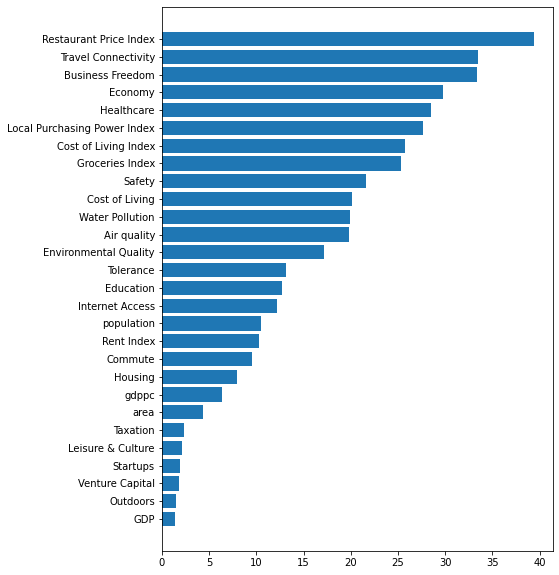

In [43]:
plt.subplots(figsize=(7,10))
plt.barh(list(reversed(columns)),list(reversed(scores)))

This graph shows how relevant each feature was in classifing cities. It is pretty suprising that Restaurant Price index was so significant. It is nice to see travel connectivity which was discussed in previous sections. Another surprising thing is that gdp per capita and gdp were not really useful. However a lot of features that are on top of the list are pretty complicated indices so this is probably why pure gdp was not so useful compared to those (some of the attributes might even be calculated using gdp).

Lastly let's see these best features on some scatter plots

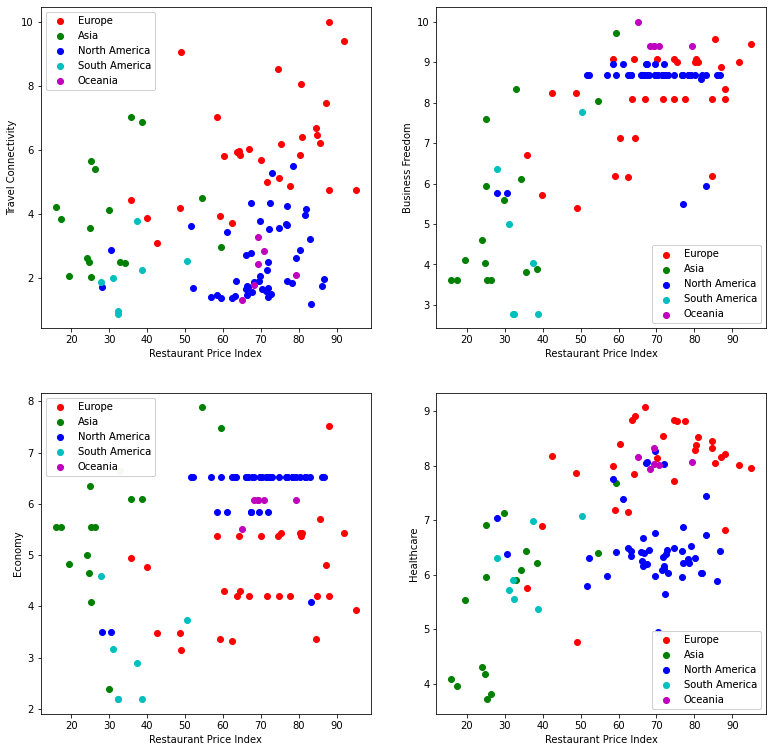

In [49]:
colors = ['r','g','b','y','c']
fig, ax = plt.subplots(2,2,figsize=(13,13))
x_axis = "Restaurant Price Index"
y_axis = "Travel Connectivity"
a = ax[0,0].scatter(cat_data[cat_data["continent"]==0][x_axis],cat_data[cat_data["continent"]==0][y_axis], label='Europe', c = 'r')
b = ax[0,0].scatter(cat_data[cat_data["continent"]==1][x_axis],cat_data[cat_data["continent"]==1][y_axis], label='Asia', c = 'g')
c = ax[0,0].scatter(cat_data[cat_data["continent"]==2][x_axis],cat_data[cat_data["continent"]==2][y_axis], label='North America', c = 'b')
d = ax[0,0].scatter(cat_data[cat_data["continent"]==3][x_axis],cat_data[cat_data["continent"]==3][y_axis], label='South America', c = 'c')
e = ax[0,0].scatter(cat_data[cat_data["continent"]==4][x_axis],cat_data[cat_data["continent"]==4][y_axis], label='Oceania', c = 'm')
ax[0,0].set_xlabel(x_axis)
ax[0,0].set_ylabel(y_axis)
legend1 = ax[0,0].legend(handles = [a,b,c,d,e], labels = conts,loc="upper left")
ax[0,0].add_artist(legend1)

y_axis = "Business Freedom"
a = ax[0,1].scatter(cat_data[cat_data["continent"]==0][x_axis],cat_data[cat_data["continent"]==0][y_axis], label='Europe', c = 'r')
b = ax[0,1].scatter(cat_data[cat_data["continent"]==1][x_axis],cat_data[cat_data["continent"]==1][y_axis], label='Asia', c = 'g')
c = ax[0,1].scatter(cat_data[cat_data["continent"]==2][x_axis],cat_data[cat_data["continent"]==2][y_axis], label='North America', c = 'b')
d = ax[0,1].scatter(cat_data[cat_data["continent"]==3][x_axis],cat_data[cat_data["continent"]==3][y_axis], label='South America', c = 'c')
e = ax[0,1].scatter(cat_data[cat_data["continent"]==4][x_axis],cat_data[cat_data["continent"]==4][y_axis], label='Oceania', c = 'm')
ax[0,1].set_xlabel(x_axis)
ax[0,1].set_ylabel(y_axis)
legend1 = ax[0,1].legend(handles = [a,b,c,d,e], labels = conts,loc="lower right")
ax[0,1].add_artist(legend1)

y_axis = "Economy"
a = ax[1,0].scatter(cat_data[cat_data["continent"]==0][x_axis],cat_data[cat_data["continent"]==0][y_axis], label='Europe', c = 'r')
b = ax[1,0].scatter(cat_data[cat_data["continent"]==1][x_axis],cat_data[cat_data["continent"]==1][y_axis], label='Asia', c = 'g')
c = ax[1,0].scatter(cat_data[cat_data["continent"]==2][x_axis],cat_data[cat_data["continent"]==2][y_axis], label='North America', c = 'b')
d = ax[1,0].scatter(cat_data[cat_data["continent"]==3][x_axis],cat_data[cat_data["continent"]==3][y_axis], label='South America', c = 'c')
e = ax[1,0].scatter(cat_data[cat_data["continent"]==4][x_axis],cat_data[cat_data["continent"]==4][y_axis], label='Oceania', c = 'm')
ax[1,0].set_xlabel(x_axis)
ax[1,0].set_ylabel(y_axis)
legend1 = ax[1,0].legend(handles = [a,b,c,d,e], labels = conts,loc="upper left")
ax[1,0].add_artist(legend1)

y_axis = "Healthcare"
a = ax[1,1].scatter(cat_data[cat_data["continent"]==0][x_axis],cat_data[cat_data["continent"]==0][y_axis], label='Europe', c = 'r')
b = ax[1,1].scatter(cat_data[cat_data["continent"]==1][x_axis],cat_data[cat_data["continent"]==1][y_axis], label='Asia', c = 'g')
c = ax[1,1].scatter(cat_data[cat_data["continent"]==2][x_axis],cat_data[cat_data["continent"]==2][y_axis], label='North America', c = 'b')
d = ax[1,1].scatter(cat_data[cat_data["continent"]==3][x_axis],cat_data[cat_data["continent"]==3][y_axis], label='South America', c = 'c')
e = ax[1,1].scatter(cat_data[cat_data["continent"]==4][x_axis],cat_data[cat_data["continent"]==4][y_axis], label='Oceania', c = 'm')
ax[1,1].set_xlabel(x_axis)
ax[1,1].set_ylabel(y_axis)
legend1 = ax[1,1].legend(handles = [a,b,c,d,e], labels = conts,loc="lower right")
ax[1,1].add_artist(legend1)


We can see some nice clusters on these plots however it also seems that a lot of the cities were assigned the same value in economy and business freedom attribute, it might be that cities from the same country receive exactly the same value in these categories.

I actually decided to rerun the notebook with these two features deleted. The lack of those has little influence on the final results. Basically random tree and random forest perform worse but other models actually improve a little. This suggests that feature selection might have been far from ideal in this notebook.

If you are interested here are the results from the rerun.

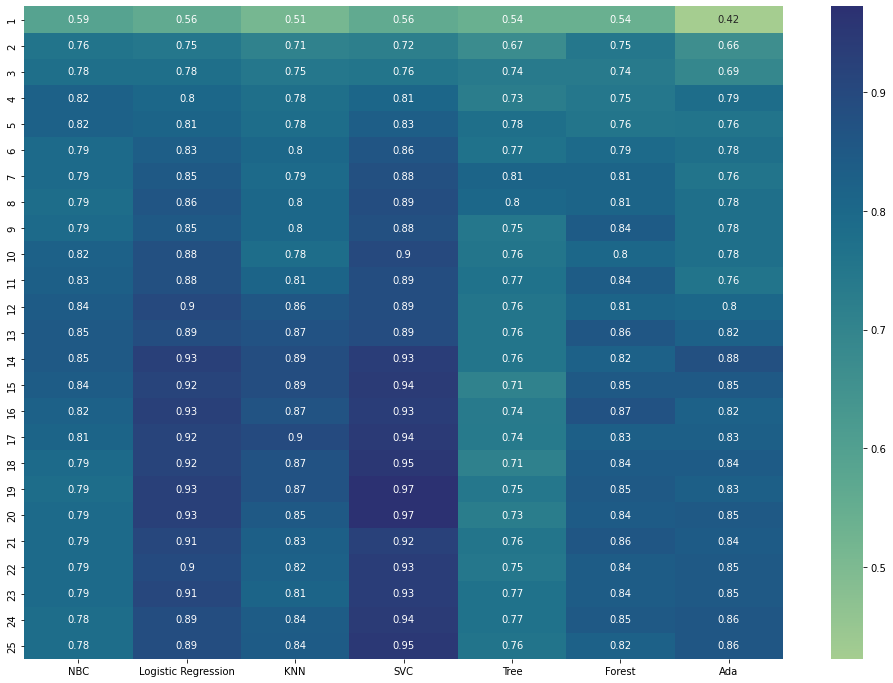

data sources:

https://www.kaggle.com/datasets/aziz69/worldcities

http://www.citymayors.com/statistics/largest-cities-area-125.html
http://www.citymayors.com/statistics/largest-cities-area-250.html

https://www.kaggle.com/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv

https://www.kaggle.com/datasets/orhankaramancode/city-quality-of-life-dataset

https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_nach_Bruttoinlandsprodukt

https://www.kaggle.com/datasets/cityapiio/world-cities-air-quality-and-water-polution

https://www.kaggle.com/datasets/debdutta/cost-of-living-index-by-country